In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as snsb
import re
from document_preprocessor import *
from nltk.tokenize import RegexpTokenizer

/Users/shawn/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
# # reload the document_preprocessor
# from importlib import reload
# import document_preprocessor
# reload(document_preprocessor)
# from document_preprocessor import *

In [3]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /Users/shawn/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
aspect = pd.read_csv('data/Aspect.csv', index_col=0)
df = pd.read_csv('./data/Google_Map_review_data.csv')
aspect = aspect[:-1] # drop the other row

## Tokenize the text

### Preprocessing
- Turn the text to lowercase
- Drop all rows with "text" field as `nan`

In [5]:
df['text'] = df['text'].str.lower()
df = df.dropna(subset=['text'], how='all')

### Tokenizing

In [6]:
class Tokenizer:
    def __init__(self, lowercase: bool = True, multiword_expressions: list[str] = None) -> None:
        """
        A generic class for objects that turn strings into sequences of tokens.
        A tokenizer can support different preprocessing options or use different methods
        for determining word breaks.

        Args:
            lowercase: Whether to lowercase all the tokens
            multiword_expressions: A list of strings that should be recognized as single tokens
                If set to 'None' no multi-word expression matching is performed.
                No need to perform/implement multi-word expression recognition for HW2.
        """
        # TODO: Save arguments that are needed as fields of this class.
        self.lowercase = lowercase
        self.multiword_expressions = multiword_expressions

    def find_and_replace_mwes(self, input_tokens: list[str]) -> list[str]:
        """
        IGNORE THIS PART; NO NEED TO IMPLEMENT THIS SINCE NO MULTI-WORD EXPRESSION PROCESSING IS TO BE USED.
        For the given sequence of tokens, finds any recognized multi-word expressions in the sequence
        and replaces that subsequence with a single token containing the multi-word expression.

        Args:
            input_tokens: A list of tokens

        Returns:
            A list of tokens containing processed multi-word expressions
        """
        # NOTE: You shouldn't implement this in homework 2
        raise NotImplemented("MWE is not supported")
    
    def postprocess(self, input_tokens: list[str]) -> list[str]:
        """
        Performs any set of optional operations to modify the tokenized list of words such as
        lower-casing and returns the modified list of tokens.

        Args:
            input_tokens: A list of tokens

        Returns:
            A list of tokens processed by lower-casing depending on the given condition
        """
        # TODO: Add support for lower-casing.
        if self.lowercase:
            for index, token in enumerate(input_tokens):
                input_tokens[index] = token.lower()

        return input_tokens
    
    def tokenize(self, text: str) -> list[str]:
        """
        Splits a string into a list of tokens and performs all required postprocessing steps.

        Args:
            text: An input text you want to tokenize

        Returns:
            A list of tokens
        """
        raise NotImplementedError('tokenize() is not implemented in the base class; please use a subclass')


In [7]:
class RegexTokenizer(Tokenizer):
    def __init__(self, token_regex: str, lowercase: bool = True, multiword_expressions: list[str] = None) -> None:
        """
        Uses NLTK's RegexpTokenizer to tokenize a given string.

        Args:
            token_regex: Use the following default regular expression pattern: '\\w+'
            lowercase: Whether to lowercase all the tokens
            multiword_expressions: A list of strings that should be recognized as single tokens
                If set to 'None' no multi-word expression matching is performed.
                No need to perform/implement multi-word expression recognition for HW2; you can ignore this.
        """
        super().__init__(lowercase, multiword_expressions)
        self.token_regex = token_regex

    def tokenize(self, text: str) -> list[str]:        
        
        tokenizer = RegexpTokenizer(self.token_regex)
        self.token_list =  tokenizer.tokenize(text)
        if self.lowercase:
            # lower casing the tokens
            self.token_list = self.postprocess(self.token_list)
        return self.token_list
    
class SpaCyTokenizer(Tokenizer):
    def tokenize(self, text: str) -> list[str]:
        """Use a spaCy tokenizer to convert named entities into single words.
        Check the spaCy documentation to learn about the feature that supports named entity recognition.

        Parameters:

        text [str]: This is an input text you want to tokenize.
        """

        nlp = spacy.load("en_core_web_lg")
        doc = nlp(text)

        return [item.text for item in doc]

In [8]:
Tokenizer = RegexpTokenizer(r'\w+')
df['text_tokenized_list'] = df['text'].apply(lambda x: Tokenizer.tokenize(x))

### Extract the stopwords from token list

In [9]:
stops = set(stopwords.words('english'))

def extract_stopwords(row):
    filtered_words = [word for word in row['text_tokenized_list'] if word.lower() not in stops]
    row['text_tokenized_list'] = filtered_words
    return row['text_tokenized_list']

df['text_tokenized_list'] = df.apply(extract_stopwords, axis=1)

## NLP the comment

In [41]:
# tok2vec, tagger, parser, attribute_ruler, lemmatizer, ner
nlp = spacy.load("en_core_web_sm", enable=['tok2vec'])

In [35]:
# tokens = nlp(df['text'][0])
# for token in tokens:
#     if not token.is_stop:
#         print(token.text, token.has_vector, token.vector_norm, token.is_oov)

electric True 7.688795 True
vehicle True 6.419941 True
charging True 8.0786 True

 True 11.255177 True
good True 7.3936872 True
location True 5.756714 True
walmart True 7.5438786 True
parking True 6.8080764 True
lot True 6.005283 True
overland True 6.701519 True
boise True 7.046694 True


In [61]:
df['text_average_pool'] = df['text'].apply(lambda x: sum([token.vector for token in nlp(x)]))
df['text_average_pool'] = df.apply(lambda x: x['text_average_pool']/len(x['text_tokenized_list']), axis=1)
df['text_average_pool'] = df['text_average_pool'].apply(lambda x: x.tolist())
data_array = np.array(df['text_average_pool'])
data_array = np.vstack(data_array)

/var/folders/nw/prlspygx479dwlhvnc1kjj8r0000gp/T/ipykernel_81931/2278361543.py:2: RuntimeWarning: divide by zero encountered in true_divide
  df['text_average_pool'] = df.apply(lambda x: x['text_average_pool']/len(x['text_tokenized_list']), axis=1)


In [65]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans

In [82]:
preprocessing = Pipeline([
    ('fillna',SimpleImputer(strategy='constant',fill_value=1)),
    ('scale',StandardScaler()),
    # ('pca', PCA(n_components=2,random_state=42)),    
])

pipe = Pipeline([
    ('preprocessing',preprocessing),
    ('kmeans', KMeans(n_clusters=2,init='k-means++',random_state=42)),
])


In [83]:
data_array[np.isinf(data_array)] = 0

In [ ]:
# from sklearn.cluster import KMeans

# k=5
# kmeans = KMeans(n_clusters=k, random_state=0)
# clusters = kmeans.fit_predict(data_array)

In [84]:
X = data_array
Xformed = preprocessing.fit_transform(data_array)
y = df['name']

/Users/shawn/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/shawn/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 2 The average silhouette_score is : 0.8998337916696224


/Users/shawn/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/shawn/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 3 The average silhouette_score is : 0.4280014785857214


/Users/shawn/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/shawn/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 4 The average silhouette_score is : 0.04875346084666043


/Users/shawn/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/shawn/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 5 The average silhouette_score is : 0.04844588198571295


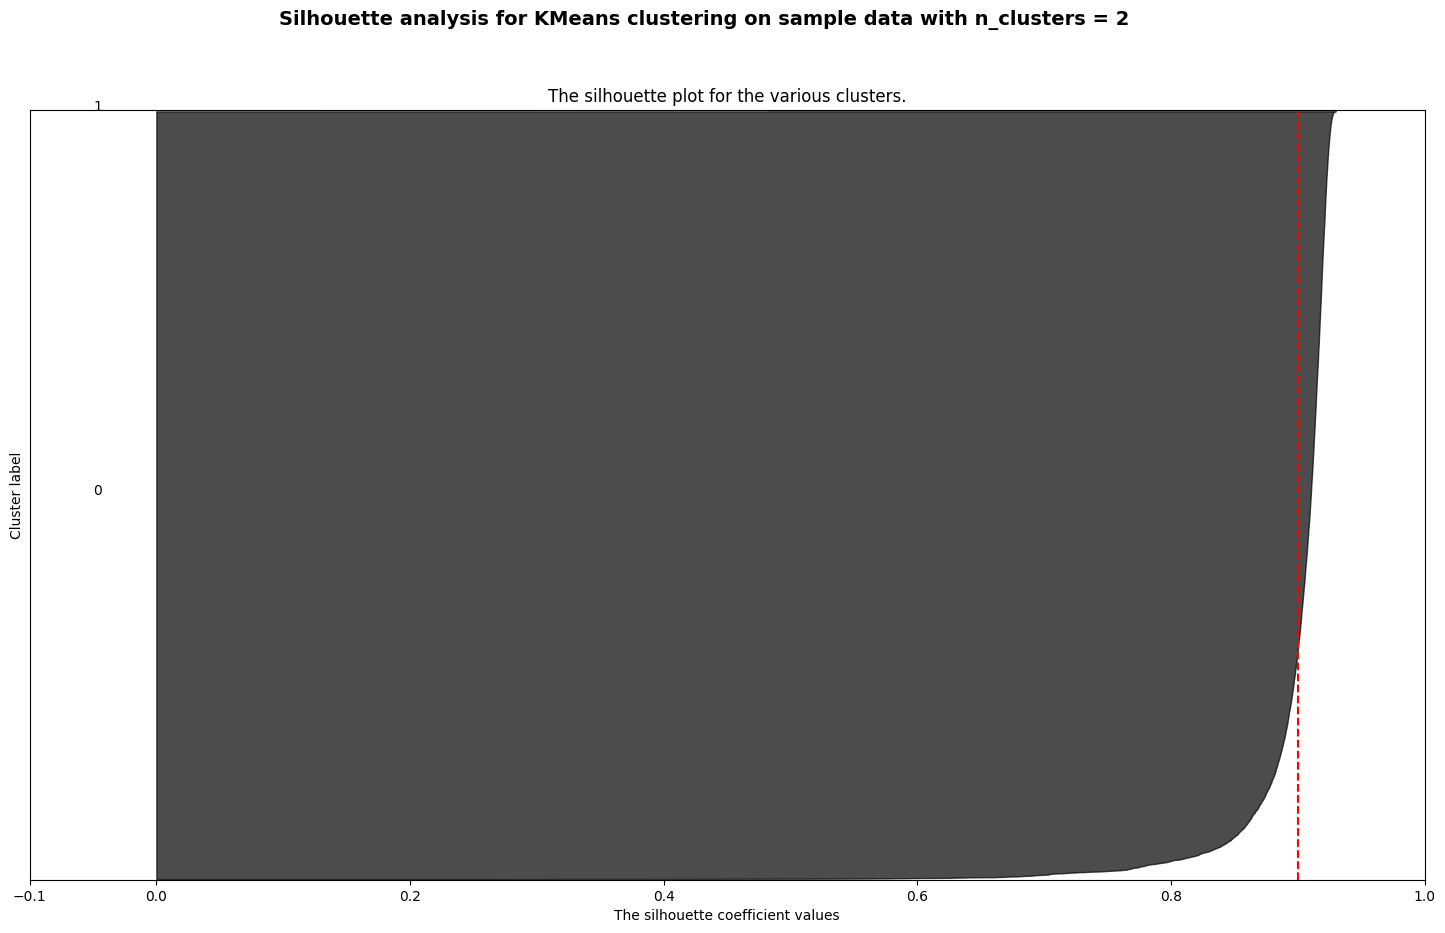

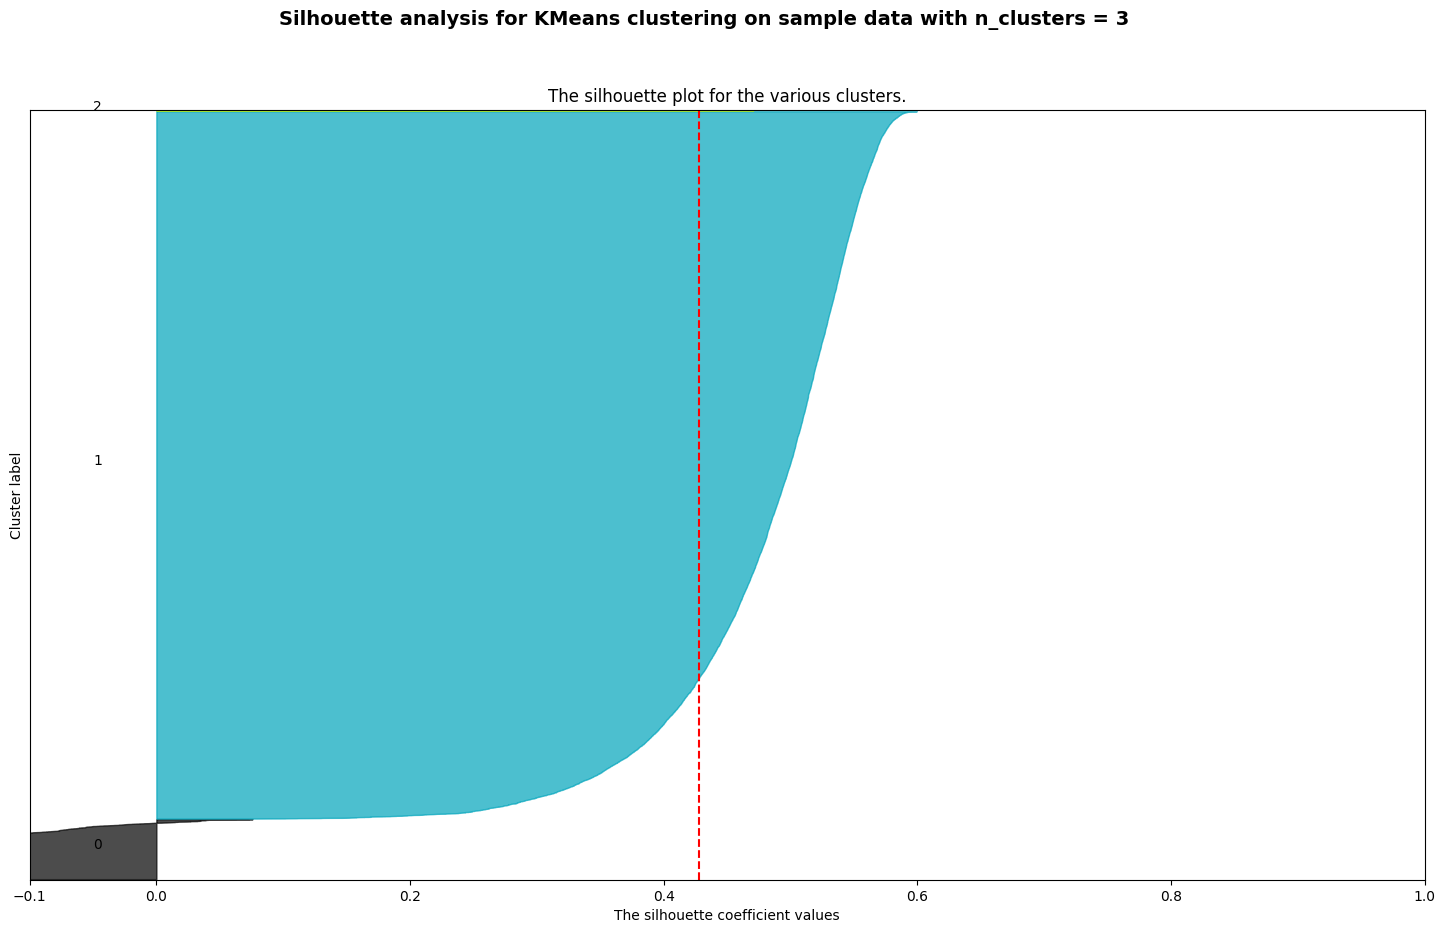

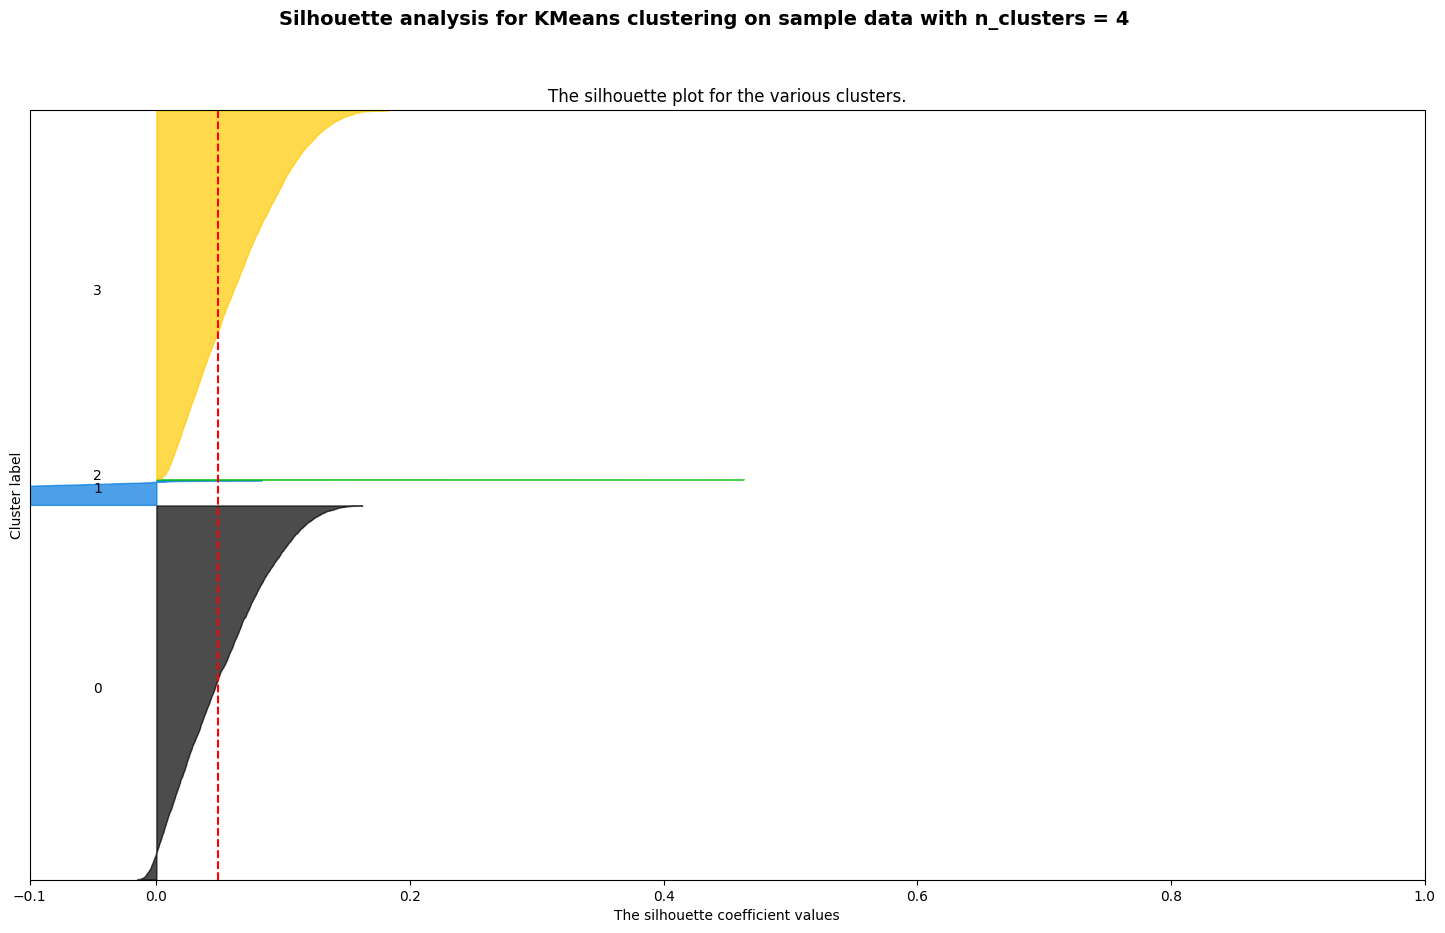

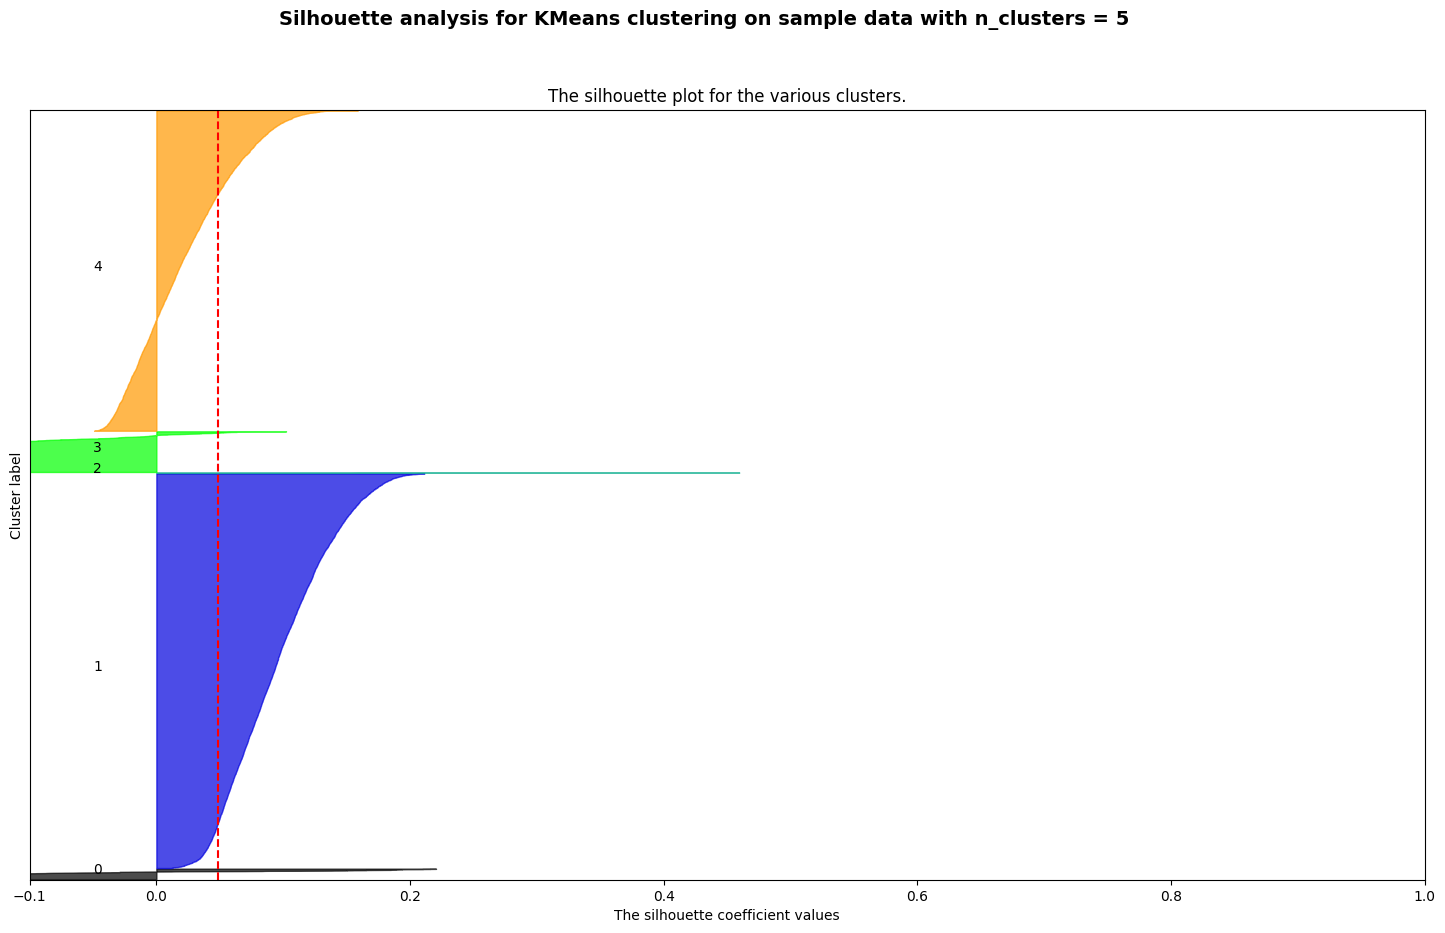

In [85]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm # colormaps
import numpy as np


range_n_clusters = [2, 3, 4, 5,]# 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
label_points = False
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots()
    fig.set_size_inches(18, 10)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(Xformed) + (n_clusters + 1) * 10])

    pipe.named_steps.kmeans.set_params(n_clusters=n_clusters,random_state=42)
    clusterer = pipe.named_steps.kmeans
    cluster_labels = pipe.fit_predict(X)
    cluster_labels = KMeans(n_clusters=n_clusters, random_state=42).fit_predict(Xformed)
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(Xformed, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(Xformed, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.savefig('silhouette%02d.pdf' % n_clusters)
plt.show()

In [39]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Load a pre-trained BERT model and tokenizer
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Sample data (replace with your labeled dataset)
comments = [
    "The availability of the product is great, but the speed is terrible.",
    "Fast delivery but limited availability.",
    "Poor availability and slow service.",
]
aspects = ["availability", "speed", "availability"]
labels = [1, 0, 0]  # Replace with your labels (1 for related, 0 for not related)

# Tokenize and prepare the data
max_seq_length = 128  # You can adjust this based on your requirements
tokenized_texts = [tokenizer.encode(comment, add_special_tokens=True, max_length=max_seq_length, truncation=True) for comment in comments]
tokenized_texts = []

nlp = spacy.load("en_core_web_sm")
tokenized_texts = [nlp(comment) for comment in comments]

input_ids = torch.tensor(tokenized_texts)
labels = torch.tensor(labels)

# Create DataLoader for batch processing
batch_size = 3
data = TensorDataset(input_ids, labels)
dataloader = DataLoader(data, batch_size=batch_size)

# Training loop (fine-tuning)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

for epoch in range(3):  # Replace with your desired number of epochs
    model.train()
    total_loss = 0.0

    for batch in dataloader:
        batch = [t.to(model.device) for t in batch]
        input_ids, labels = batch
        optimizer.zero_grad()
        outputs = model(input_ids, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    average_loss = total_loss / len(dataloader)

    print(f"Epoch {epoch + 1} - Average Loss: {average_loss}")

# Inference
model.eval()
aspect_scores = []

for comment in comments:
    tokenized_text = tokenizer.encode(comment, add_special_tokens=True, max_length=max_seq_length, truncation=True)
    input_ids = torch.tensor(tokenized_text).unsqueeze(0)  # Batch size of 1
    with torch.no_grad():
        outputs = model(input_ids)
    logits = outputs.logits
    aspect_score = torch.sigmoid(logits[0]).item()  # Convert logits to a score between 0 and 1
    aspect_scores.append(aspect_score)

print("Aspect Scores:", aspect_scores)
aspect

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ValueError: expected sequence of length 16 at dim 1 (got 8)

,name,business_status,address,lat,lng,types,rating,user_ratings_total,#charging_stations,text,author_name,author_url,relative_time_description,time,Unnamed: 14,text_tokenized_list
0,Electrify America Charging Station,OPERATIONAL,"8300 W Overland Rd, Boise, ID 83709, USA",43.591650,-116.283556,"point_of_interest, establishment",5,9,5,electric vehicle charging\ngood location in wa...,Anmar Abdullah,https://www.google.com/maps/contrib/1149397606...,7 months ago,2022-09-25 21:33:44,0,"[electric, vehicle, charging, good, location, ..."
1,Electrify America Charging Station,OPERATIONAL,"8300 W Overland Rd, Boise, ID 83709, USA",43.591650,-116.283556,"point_of_interest, establishment",4,9,5,the rates seem a little high and i often find ...,Space Ghost,https://www.google.com/maps/contrib/1005346496...,4 months ago,2023-01-06 2:41:54,0,"[rates, seem, little, high, often, find, least..."
2,Electrify America Charging Station,OPERATIONAL,"8300 W Overland Rd, Boise, ID 83709, USA",43.591650,-116.283556,"point_of_interest, establishment",1,9,5,tried 3 different chargers . still couldn’t ge...,Roxanna Todd,https://www.google.com/maps/contrib/1171099222...,4 months ago,2022-12-18 23:50:11,0,"[tried, 3, different, chargers, still, get, wo..."
3,Electrify America Charging Station,OPERATIONAL,"8300 W Overland Rd, Boise, ID 83709, USA",43.591650,-116.283556,"point_of_interest, establishment",3,9,5,there's always at least one charger not workin...,Andy Jensen,https://www.google.com/maps/contrib/1112728836...,7 months ago,2022-10-12 22:01:23,0,"[always, least, one, charger, working, activat..."
4,Electrify America Charging Station,OPERATIONAL,"8300 W Overland Rd, Boise, ID 83709, USA",43.591650,-116.283556,"point_of_interest, establishment",2,9,5,frustrating as hell! most of them require a 2...,John Hudson,https://www.google.com/maps/contrib/1025132783...,9 months ago,2022-07-24 2:35:54,0,"[frustrating, hell, require, 2nd, 3rd, try, ge..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16749,Tesla Destination Charger,OPERATIONAL,"1597 Esmeralda Ave, Minden, NV 89423, USA",38.953601,-119.763554,"point_of_interest, establishment",5,2,2,fast and free! thank you!!,Matthew Zavislak,https://www.google.com/maps/contrib/1061564432...,2 years ago,2020-08-28 23:57:11,0,"[fast, free, thank]"
16759,Tesla Supercharger,OPERATIONAL,"41 Simcoe Plaza, Terrace Bay, ON P0T 2W0, Canada",48.783022,-87.099836,"point_of_interest, establishment",3,7,5,nice charger but had to unhitch trailer to cha...,Lyn Chaffart,https://www.google.com/maps/contrib/1010384106...,a year ago,2021-07-27 21:17:14,1,"[nice, charger, unhitch, trailer, charge, howe..."
16760,Tesla Supercharger,OPERATIONAL,"41 Simcoe Plaza, Terrace Bay, ON P0T 2W0, Canada",48.783022,-87.099836,"point_of_interest, establishment",5,7,5,"chargers are a little slow (100kw), but good l...",Steve Ringer,https://www.google.com/maps/contrib/1002411228...,a year ago,2021-09-01 0:59:20,1,"[chargers, little, slow, 100kw, good, location..."
16761,Tesla Supercharger,OPERATIONAL,"41 Simcoe Plaza, Terrace Bay, ON P0T 2W0, Canada",48.783022,-87.099836,"point_of_interest, establishment",5,7,5,fast charge. only one there,M Tamaki,https://www.google.com/maps/contrib/1119286785...,a year ago,2021-09-14 23:53:50,1,"[fast, charge, one]"


In [86]:
df

,name,business_status,address,lat,lng,types,rating,user_ratings_total,#charging_stations,text,author_name,author_url,relative_time_description,time,Unnamed: 14,text_tokenized_list,text_average_pool
0,Electrify America Charging Station,OPERATIONAL,"8300 W Overland Rd, Boise, ID 83709, USA",43.591650,-116.283556,"point_of_interest, establishment",5,9,5,electric vehicle charging\ngood location in wa...,Anmar Abdullah,https://www.google.com/maps/contrib/1149397606...,7 months ago,2022-09-25 21:33:44,0,"[electric, vehicle, charging, good, location, ...","[-0.02009713277220726, -0.24332070350646973, 0..."
1,Electrify America Charging Station,OPERATIONAL,"8300 W Overland Rd, Boise, ID 83709, USA",43.591650,-116.283556,"point_of_interest, establishment",4,9,5,the rates seem a little high and i often find ...,Space Ghost,https://www.google.com/maps/contrib/1005346496...,4 months ago,2023-01-06 2:41:54,0,"[rates, seem, little, high, often, find, least...","[0.24622748792171478, -0.2441510111093521, 0.0..."
2,Electrify America Charging Station,OPERATIONAL,"8300 W Overland Rd, Boise, ID 83709, USA",43.591650,-116.283556,"point_of_interest, establishment",1,9,5,tried 3 different chargers . still couldn’t ge...,Roxanna Todd,https://www.google.com/maps/contrib/1171099222...,4 months ago,2022-12-18 23:50:11,0,"[tried, 3, different, chargers, still, get, wo...","[-1.0807387828826904, -0.6370962858200073, -0...."
3,Electrify America Charging Station,OPERATIONAL,"8300 W Overland Rd, Boise, ID 83709, USA",43.591650,-116.283556,"point_of_interest, establishment",3,9,5,there's always at least one charger not workin...,Andy Jensen,https://www.google.com/maps/contrib/1112728836...,7 months ago,2022-10-12 22:01:23,0,"[always, least, one, charger, working, activat...","[-0.2067181020975113, -0.5280864238739014, 0.2..."
4,Electrify America Charging Station,OPERATIONAL,"8300 W Overland Rd, Boise, ID 83709, USA",43.591650,-116.283556,"point_of_interest, establishment",2,9,5,frustrating as hell! most of them require a 2...,John Hudson,https://www.google.com/maps/contrib/1025132783...,9 months ago,2022-07-24 2:35:54,0,"[frustrating, hell, require, 2nd, 3rd, try, ge...","[-0.7115918397903442, -1.0148556232452393, -0...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16749,Tesla Destination Charger,OPERATIONAL,"1597 Esmeralda Ave, Minden, NV 89423, USA",38.953601,-119.763554,"point_of_interest, establishment",5,2,2,fast and free! thank you!!,Matthew Zavislak,https://www.google.com/maps/contrib/1061564432...,2 years ago,2020-08-28 23:57:11,0,"[fast, free, thank]","[-1.4782447814941406, -1.0317693948745728, -0...."
16759,Tesla Supercharger,OPERATIONAL,"41 Simcoe Plaza, Terrace Bay, ON P0T 2W0, Canada",48.783022,-87.099836,"point_of_interest, establishment",3,7,5,nice charger but had to unhitch trailer to cha...,Lyn Chaffart,https://www.google.com/maps/contrib/1010384106...,a year ago,2021-07-27 21:17:14,1,"[nice, charger, unhitch, trailer, charge, howe...","[-0.032360807061195374, -0.640982985496521, -0..."
16760,Tesla Supercharger,OPERATIONAL,"41 Simcoe Plaza, Terrace Bay, ON P0T 2W0, Canada",48.783022,-87.099836,"point_of_interest, establishment",5,7,5,"chargers are a little slow (100kw), but good l...",Steve Ringer,https://www.google.com/maps/contrib/1002411228...,a year ago,2021-09-01 0:59:20,1,"[chargers, little, slow, 100kw, good, location...","[-0.04701629653573036, -0.1814136803150177, -0..."
16761,Tesla Supercharger,OPERATIONAL,"41 Simcoe Plaza, Terrace Bay, ON P0T 2W0, Canada",48.783022,-87.099836,"point_of_interest, establishment",5,7,5,fast charge. only one there,M Tamaki,https://www.google.com/maps/contrib/1119286785...,a year ago,2021-09-14 23:53:50,1,"[fast, charge, one]","[-0.9773069024085999, -1.8354741334915161, -0...."


In [32]:
tokens[0].vector

array([-0.5690763 , -0.8732642 ,  0.5128311 ,  0.72345346, -1.2202679 ,
       -0.09541509,  0.55608916, -0.3399236 , -0.20594269, -0.85478735,
        0.27049392,  0.22676635, -0.26915187, -1.4263816 , -1.4211246 ,
        0.06407225, -0.32784718, -0.15400368, -0.79449403,  0.2805522 ,
       -1.470798  ,  1.0819771 ,  0.482197  ,  0.7472607 ,  0.29374978,
        1.3647273 ,  0.40247992,  0.7366739 ,  0.5250346 , -0.17616022,
       -0.92920995, -0.77130824, -0.59289896, -0.3140336 , -0.82065815,
        0.10371596,  0.4681673 , -0.18761937, -0.92134655,  1.1509416 ,
       -1.1575813 ,  1.9369082 , -0.9453851 ,  0.76626456, -0.06066981,
       -0.22787946,  0.2927705 , -0.22549516,  0.46824288,  1.362201  ,
       -0.29997888,  1.3315941 , -0.5931814 , -0.7507576 , -0.9373914 ,
        0.39933512,  0.35918158,  0.37019894, -0.13960186,  0.514367  ,
       -0.84256065, -1.6033375 ,  0.60654986, -1.968399  , -0.22122976,
        0.05591705,  0.45771426,  1.3195677 , -0.3977357 , -0.86